# Домашнее задание:
## Сравнение детекторов на примере детекции игроков в спорте

Необходимо обучить на целевом датасете (игроки в спорте) два типа детекторов: 1) Detectron2 (семейтсво R-CNN) и 2) Ultralytics (семейство YOLO). После обучения нужно замерить метрику mAP для разных моделей и сравнить результаты. Необходимо продемонстрировать код и сводную таблицу с результатами.

### Задачи:
1) Обучить любую модель из [Detectron2](https://github.com/facebookresearch/detectron2) детектировать игроков в баскетбольном матче. Число классов: 2 (две команды). В качестве начальной модели взять любую из [предобученных моделей](https://github.com/facebookresearch/detectron2/blob/main/MODEL_ZOO.md) (Faster R-CNN или RetinaNet). Перед обучением, необходимо привести целевой датасет к формату detectron2. Пример того, как обучать Detectron2 на своем датасете можно найти [здесь](https://colab.research.google.com/drive/1Xdm2KrBauT0lEyKFEiLie7nhzXajgEkH?usp=sharing). Посчитать метрику COCO mAP.

2) Обучить любую модель из [Ultralytics](https://github.com/ultralytics/ultralytics) (YOLOv8, YOLOv9, YOLOv10). В качестве начальной модели необходимо взять предобученную модель (например, yolov8n.pt). Необходимо также адаптировать целевой датасет к формату Ultralytics. Пример того, как обучить YOLOv8 на своем датасете можно найти [здесь](https://colab.research.google.com/drive/1fPZT1d-EBuYdDgXAmfnlKhkFilRnrjGj?usp=sharing). Посчитать метрику COCO mAP.
<br> 2.1 - Преобразование анотации датасета в формат для обучения YOLO
<br> 2.2 - Проверка на валидность данных
<br> 2.3 - Визуальный контроль датасета
<br> 2.4 - Обучение модели YOLO v11m
<br> 2.5 - Инферен обученой модели
<br> 2.6 - Вывод метрики COCO mAP

3) Обучить модель из Ultralytics с нуля (from scratch), аналогично п.2.
<br> 3.1 - Инферен обученой модели
<br> 3.2 - Вывод метрики COCO mAP

4) Протестировать модель "из коробки" из Ultralytics (т.е. без дообучения) и посчитать mAP для тестовой выборки.
<br> 4.1 - Инферен обученой модели
<br> 4.2 - Вывод метрики COCO mAP

5) Свести в единую таблицу результаты всех моделей (по метрике mAP), сравнить и сделать выводы (точность, скорость обучения, эффект предобучения, удобство работы с фреймворком (detectron2 и ultralitics).


In [46]:
%matplotlib inline
import torch
import ultralytics
import json
import os
from pathlib import Path
import shutil
from ultralytics import YOLO
import cv2
import yaml
import matplotlib.pyplot as plt
from PIL import Image
import glob
import random
from IPython.display import Image
import matplotlib.patches as patches
import pandas as pd
import numpy as np

# 2 Обучение модели из Ultalitics

## 2.1 Преобразование анотации датасета в формат для обучения YOLO

In [ ]:
# Преобразование
def convert_annotations(json_path, images_dir, labels_dir):
    os.makedirs(labels_dir, exist_ok=True)
    
    with open(json_path, 'r') as f:
        annotations = json.load(f)
    
    for img_name, objects in annotations.items():
        img_path = os.path.join(images_dir, img_name)
        if not os.path.exists(img_path):
            print(f"Warning: {img_path} does not exist. Skipping.")
            continue
        
        txt_filename = os.path.splitext(img_name)[0] + '.txt'
        txt_path = os.path.join(labels_dir, txt_filename)
        
        with open(txt_path, 'w') as txt_file:
            for obj_id, obj_info in objects.items():
                if 'team' not in obj_info:
                    continue
                class_id = obj_info['team']
                # [x_min, y_min, width, height]
                x_min, y_min, w, h = obj_info['box']
                # YOLO формат [x_center, y_center, width, height]
                x_center = x_min + w / 2
                y_center = y_min + h / 2
                line = f"{class_id} {x_center} {y_center} {w} {h}\n"
                txt_file.write(line)

# Пути к данным
base_path = "otus_basketball_dataset/"

# Обработка тренировочных данных
# convert_annotations(
#     json_path=os.path.join(base_path, "anno_train.json"),
#     images_dir=os.path.join(base_path, "images_train"),
#     labels_dir=os.path.join(base_path, "labels_train")
# )

# # Обработка тестовых данных
# convert_annotations(
#     json_path=os.path.join(base_path, "anno_test.json"),
#     images_dir=os.path.join(base_path, "images_test"),
#     labels_dir=os.path.join(base_path, "labels_test")
# )

## 2.2 Предоставленный датасе был с некоректными координатам. Делаю проверку на валидность данных.
На самом деле проверка была выполнее на более ранних этапах работы п2

In [ ]:
# Проверка на валидность датасета
def validate_yolo_dataset(dataset_path):
    for split in ['train', 'valid']:
        labels_dir = os.path.join(dataset_path, split, 'labels')
        images_dir = os.path.join(dataset_path, split, 'images')
        
        if not os.path.exists(labels_dir) or not os.path.exists(images_dir):
            print(f"Пропускаем {split}: отсутствуют директории labels/images")
            continue
        
        for label_file in glob.glob(os.path.join(labels_dir, '*.txt')):
            is_valid = True
            image_file = None
            
            base_name = os.path.splitext(os.path.basename(label_file))[0]
            
            for ext in ['.jpg', '.jpeg', '.png', '.bmp', '.gif']:
                possible_image = os.path.join(images_dir, base_name + ext)
                if os.path.exists(possible_image):
                    image_file = possible_image
                    break
            
            try:
                with open(label_file, 'r') as f:
                    lines = f.readlines()
            except Exception as e:
                print(f"Ошибка чтения {label_file}: {e}")
                is_valid = False
            else:
                for line_num, line in enumerate(lines, 1):
                    line = line.strip()
                    if not line:
                        continue
                    
                    parts = line.split()
                    
                    # Проверка класса
                    try:
                        class_id = int(parts[0])
                        if class_id < 0:
                            print(f"Отрицательный класс в строке {line_num} файла {label_file}")
                            is_valid = False
                            break
                    except (ValueError, IndexError):
                        print(f"Неверный формат класса в строке {line_num} файла {label_file}")
                        is_valid = False
                        break
                    
                    # Проверка координат (первые 4 значения после класса)
                    for i in range(1, 5):
                        try:
                            coord = parts[i]
                            val = float(coord)
                            if not (0.0 <= val <= 1.0):
                                print(f"Некорректное значение координаты {i} в строке {line_num} файла {label_file}: {val}")
                                is_valid = False
                                break
                        except (ValueError, IndexError):
                            print(f"Ошибка в координате {i} строки {line_num} файла {label_file}")
                            is_valid = False
                            break
                    if not is_valid:
                        break
            
            if not is_valid:
                print(f"Удаление невалидной аннотации: {label_file}")
                os.remove(label_file)
                if image_file:
                    print(f"Удаление соответствующего изображения: {image_file}")
                    os.remove(image_file)
                else:
                    print(f"Соответствующее изображение не найдено для {label_file}")

# Пример использования
validate_yolo_dataset('otus_basketball_dataset')

In [ ]:
# Функция отбора рандомных изображений из датасета
def get_random_image_name(base_path):
    images_dir = os.path.join(base_path, "train", "images")
    image_files = [f for f in os.listdir(images_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    return random.choice(image_files)

## 2.3 Выполняю визуальный контроль датасета

otus_basketball_dataset\train\images\066593.jpeg
otus_basketball_dataset\train\labels\066593.txt


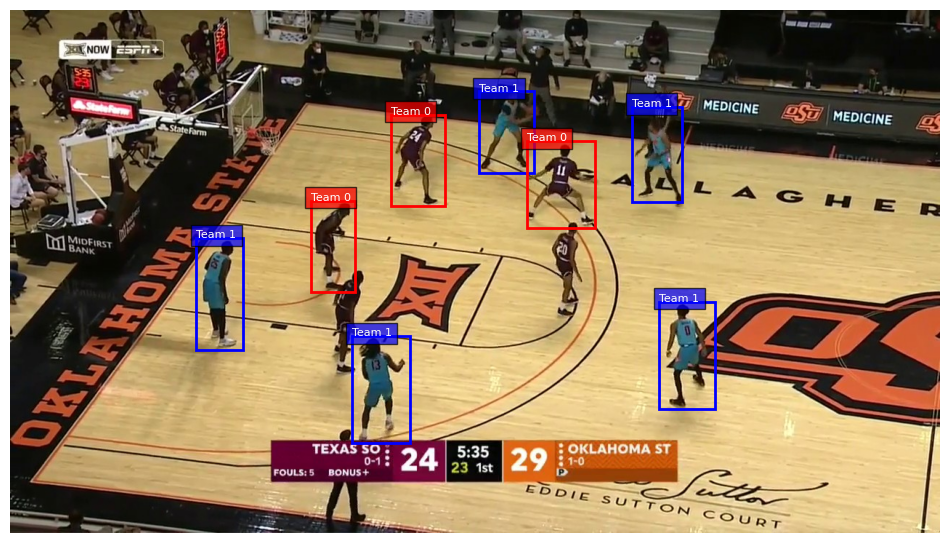

In [36]:
from PIL import Image
base_path = "otus_basketball_dataset"

# Выбор изображения для визуализации
sample_image = get_random_image_name(base_path)  # Замените на имя из вашего датасета
image_path = os.path.join(base_path, "train", "images", sample_image)  # Добавлена папка images
label_path = os.path.join(base_path, "train", "labels", sample_image.replace(".jpeg", ".txt")) 
print(image_path)
print(label_path)

# Загрузка изображения
image = Image.open(image_path)
img_width, img_height = image.size

# Создание фигуры
fig, ax = plt.subplots(1, figsize=(12, 8))
ax.imshow(image)

# Чтение аннотаций YOLO
with open(label_path, 'r') as f:
    annotations = f.readlines()

# Отрисовка BBox
for line in annotations:
    class_id, x_center, y_center, w, h = map(float, line.strip().split())
    x_center *= img_width
    y_center *= img_height
    w *= img_width
    h *= img_height
    x_min = x_center - w /2
    y_min = y_center - h /2
    
    rect = patches.Rectangle(
        (x_min, y_min), w, h,
        linewidth=2, edgecolor='r' if class_id == 0 else 'b', facecolor='none'
    )
    ax.add_patch(rect)
    plt.text(x_min, y_min, f'Team {int(class_id)}', 
             color='white', fontsize=8, 
             bbox=dict(facecolor='red' if class_id == 0 else 'blue', alpha=0.7))

plt.axis('off')
plt.show()

## 2.4 Обучение YOLO v11m

In [ ]:
# Загрузка предобученной модели
model = YOLO("yolo11m.pt")

In [ ]:
results = model.train(
    data="basketball.yaml",
    epochs=50,
    batch=8,
    imgsz=640,
    device="CUDA",  # GPU 
    name="basketball_detection",
    workers=0     
)

Ultralytics 8.3.145  Python-3.11.9 torch-2.7.0+cu128 CUDA:0 (NVIDIA GeForce RTX 4090, 24564MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=basketball.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11m.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=basketball_detection, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0,

100%|██████████| 5.35M/5.35M [00:14<00:00, 391kB/s] 


AMP: checks passed 
train: Fast image access  (ping: 0.10.0 ms, read: 2179.31121.6 MB/s, size: 207.8 KB)


train: Scanning C:\Users\khari\OneDrive\Документы\GirRep\OtusCV\Lesson 17\Homework\otus_basketball_dataset\train\labels.cache... 399 images, 0 backgrounds, 0 corrupt: 100%|██████████| 399/399 [00:00<?, ?it/s]

val: Fast image access  (ping: 0.00.0 ms, read: 3008.8911.8 MB/s, size: 220.5 KB)



val: Scanning C:\Users\khari\OneDrive\Документы\GirRep\OtusCV\Lesson 17\Homework\otus_basketball_dataset\valid\labels.cache... 100 images, 0 backgrounds, 0 corrupt: 100%|██████████| 100/100 [00:00<?, ?it/s]


Plotting labels to runs\detect\basketball_detection\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 106 weight(decay=0.0), 113 weight(decay=0.0005), 112 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs\detect\basketball_detection
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      4.25G      1.544      1.719      1.178        113        640: 100%|██████████| 50/50 [00:19<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.82it/s]

                   all        100        660      0.622      0.782       0.66      0.324



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      4.32G      1.452       1.17      1.186         91        640: 100%|██████████| 50/50 [00:13<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.72it/s]

                   all        100        660      0.643      0.867      0.677       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      4.41G      1.567       1.19      1.264         85        640: 100%|██████████| 50/50 [00:13<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.76it/s]

                   all        100        660      0.612      0.839      0.636      0.332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      4.43G      1.448      1.098      1.209        129        640: 100%|██████████| 50/50 [00:15<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.62it/s]

                   all        100        660      0.588       0.84      0.674      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      4.46G      1.426       1.08      1.195         81        640: 100%|██████████| 50/50 [00:20<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.48it/s]


                   all        100        660      0.634      0.863      0.667      0.387

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      4.53G      1.462      1.086      1.216         94        640: 100%|██████████| 50/50 [00:19<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.18it/s]

                   all        100        660      0.614      0.809      0.638      0.353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      4.82G      1.362       0.99       1.18         75        640: 100%|██████████| 50/50 [00:20<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.45it/s]

                   all        100        660       0.66      0.886      0.666      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      4.89G      1.374     0.9576       1.19        114        640: 100%|██████████| 50/50 [00:20<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.98it/s]


                   all        100        660      0.664      0.875      0.698      0.402

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      4.95G      1.387      0.934      1.176         75        640: 100%|██████████| 50/50 [00:17<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.64it/s]

                   all        100        660      0.661      0.892      0.673      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      4.95G      1.364     0.9483      1.183         99        640: 100%|██████████| 50/50 [00:13<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.67it/s]

                   all        100        660      0.667      0.895      0.695      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      4.96G      1.312     0.9039       1.16         62        640: 100%|██████████| 50/50 [00:13<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.65it/s]

                   all        100        660      0.661       0.89      0.674      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      5.02G       1.34     0.9351      1.177         88        640: 100%|██████████| 50/50 [00:13<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.72it/s]

                   all        100        660      0.666      0.887      0.695      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      5.02G      1.331     0.9044      1.166         98        640: 100%|██████████| 50/50 [00:13<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.63it/s]

                   all        100        660      0.666      0.887      0.689      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      5.02G      1.303     0.8863      1.143         85        640: 100%|██████████| 50/50 [00:13<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.72it/s]

                   all        100        660      0.666      0.886      0.699      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      5.02G      1.286     0.8906      1.143         86        640: 100%|██████████| 50/50 [00:13<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.72it/s]

                   all        100        660      0.647      0.908      0.681       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      5.02G      1.272     0.8753       1.14         63        640: 100%|██████████| 50/50 [00:13<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.93it/s]

                   all        100        660      0.674      0.906      0.694      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      5.02G       1.25     0.8684      1.129         98        640: 100%|██████████| 50/50 [00:13<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.70it/s]

                   all        100        660      0.657      0.903      0.696      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      5.02G      1.242     0.8514      1.114        100        640: 100%|██████████| 50/50 [00:13<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.10it/s]

                   all        100        660      0.675      0.906      0.707      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      5.02G      1.206     0.8452      1.114         88        640: 100%|██████████| 50/50 [00:13<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.93it/s]

                   all        100        660      0.678      0.905      0.717      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      5.02G       1.21     0.8407      1.115         54        640: 100%|██████████| 50/50 [00:13<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.75it/s]

                   all        100        660      0.673      0.895      0.688      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      5.02G      1.214     0.8387      1.097         73        640: 100%|██████████| 50/50 [00:13<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.72it/s]

                   all        100        660      0.678      0.901      0.713      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      5.02G      1.185     0.8157      1.088         84        640: 100%|██████████| 50/50 [00:13<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.73it/s]

                   all        100        660      0.675      0.901      0.699      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      5.02G      1.181     0.8236      1.107         79        640: 100%|██████████| 50/50 [00:13<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.75it/s]

                   all        100        660      0.679        0.9      0.709       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      5.02G       1.22     0.8212      1.097        106        640: 100%|██████████| 50/50 [00:13<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.97it/s]

                   all        100        660      0.675      0.908      0.738      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      5.02G      1.174     0.8147      1.077        110        640: 100%|██████████| 50/50 [00:13<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.72it/s]

                   all        100        660      0.671        0.9      0.727      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      5.02G      1.178     0.8156       1.08         96        640: 100%|██████████| 50/50 [00:13<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.91it/s]

                   all        100        660      0.673      0.906      0.714      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      5.02G      1.166     0.8011      1.088        117        640: 100%|██████████| 50/50 [00:13<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.88it/s]

                   all        100        660      0.672      0.897      0.701      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      5.02G      1.152      0.784      1.094        110        640: 100%|██████████| 50/50 [00:13<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.97it/s]

                   all        100        660       0.68      0.901      0.694      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      5.02G      1.149     0.7923      1.072         99        640: 100%|██████████| 50/50 [00:13<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.96it/s]

                   all        100        660      0.679      0.908      0.697      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      5.02G      1.137     0.7709      1.062         95        640: 100%|██████████| 50/50 [00:13<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.09it/s]

                   all        100        660      0.679      0.911      0.711      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      5.02G       1.11     0.7689      1.064        104        640: 100%|██████████| 50/50 [00:13<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.08it/s]

                   all        100        660       0.68       0.89      0.724      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      5.02G      1.104     0.7592      1.057         68        640: 100%|██████████| 50/50 [00:13<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.72it/s]

                   all        100        660      0.676      0.894      0.718      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      5.02G      1.104      0.769      1.052         78        640: 100%|██████████| 50/50 [00:14<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.42it/s]

                   all        100        660       0.68      0.886      0.703      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      5.02G      1.105     0.7664      1.055        121        640: 100%|██████████| 50/50 [00:13<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.69it/s]

                   all        100        660      0.687      0.883      0.722      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      5.02G      1.079     0.7509      1.045        117        640: 100%|██████████| 50/50 [00:13<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.78it/s]

                   all        100        660      0.675      0.906      0.723      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      5.02G      1.084     0.7492       1.06        140        640: 100%|██████████| 50/50 [00:13<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.75it/s]

                   all        100        660      0.691       0.88      0.712      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      5.02G      1.051     0.7273      1.047         73        640: 100%|██████████| 50/50 [00:13<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.74it/s]

                   all        100        660      0.684      0.892       0.72      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      5.02G      1.055     0.7485      1.046         86        640: 100%|██████████| 50/50 [00:13<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.73it/s]

                   all        100        660      0.684      0.882      0.712      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      5.02G      1.053     0.7261       1.03         86        640: 100%|██████████| 50/50 [00:13<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.74it/s]

                   all        100        660      0.676      0.897      0.705      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      5.02G      1.055     0.7281      1.037         93        640: 100%|██████████| 50/50 [00:13<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.66it/s]

                   all        100        660      0.685      0.893       0.72      0.454


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      5.02G      1.064     0.7178       1.08         51        640: 100%|██████████| 50/50 [00:13<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.57it/s]

                   all        100        660      0.681      0.891      0.715      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      5.02G     0.9927     0.6838      1.038         46        640: 100%|██████████| 50/50 [00:13<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.50it/s]

                   all        100        660      0.688      0.882      0.705      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      5.02G     0.9868     0.6778      1.034         52        640: 100%|██████████| 50/50 [00:13<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.61it/s]

                   all        100        660      0.685      0.895      0.715      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      5.02G     0.9687     0.6797      1.042         49        640: 100%|██████████| 50/50 [00:13<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.61it/s]

                   all        100        660       0.68      0.893      0.722      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      5.02G     0.9417     0.6582       1.02         46        640: 100%|██████████| 50/50 [00:13<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.96it/s]

                   all        100        660      0.685      0.898       0.71      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      5.08G     0.9494     0.6588      1.025         48        640: 100%|██████████| 50/50 [00:13<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.74it/s]

                   all        100        660      0.676      0.893      0.714      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      5.08G     0.9414     0.6524      1.019         48        640: 100%|██████████| 50/50 [00:12<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.86it/s]

                   all        100        660      0.679      0.891      0.708      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      5.08G     0.9166     0.6433      1.005         43        640: 100%|██████████| 50/50 [00:13<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.69it/s]

                   all        100        660      0.669      0.907      0.708      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      5.08G     0.9098     0.6381      1.013         53        640: 100%|██████████| 50/50 [00:13<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.74it/s]

                   all        100        660      0.673      0.914       0.71      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      5.08G     0.8923     0.6292     0.9984         53        640: 100%|██████████| 50/50 [00:12<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.71it/s]

                   all        100        660       0.67      0.913      0.711      0.463



50 epochs completed in 0.231 hours.
Optimizer stripped from runs\detect\basketball_detection\weights\last.pt, 40.5MB
Optimizer stripped from runs\detect\basketball_detection\weights\best.pt, 40.5MB

Validating runs\detect\basketball_detection\weights\best.pt...
Ultralytics 8.3.145  Python-3.11.9 torch-2.7.0+cu128 CUDA:0 (NVIDIA GeForce RTX 4090, 24564MiB)
YOLO11m summary (fused): 125 layers, 20,031,574 parameters, 0 gradients, 67.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.86it/s]


                   all        100        660      0.674      0.908      0.738      0.475
                 team0        100        377       0.77      0.907      0.801      0.518
                 team1        100        283      0.579      0.908      0.675      0.432
Speed: 0.6ms preprocess, 1.5ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to runs\detect\basketball_detection


## 2.5 Инферен обученой модели

In [ ]:
# Загрузите дообученой модели
model = YOLO("runs/detect/basketball_detection/weights/best.pt")


image 1/1 c:\Users\khari\OneDrive\\GirRep\OtusCV\Lesson 17\Homework\otus_basketball_dataset\valid\images\080744.jpeg: 384x640 5 team0s, 5 team1s, 180.8ms
Speed: 4.5ms preprocess, 180.8ms inference, 9.3ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 c:\Users\khari\OneDrive\\GirRep\OtusCV\Lesson 17\Homework\otus_basketball_dataset\valid\images\085127.jpeg: 384x640 3 team0s, 2 team1s, 117.8ms
Speed: 2.1ms preprocess, 117.8ms inference, 9.4ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 c:\Users\khari\OneDrive\\GirRep\OtusCV\Lesson 17\Homework\otus_basketball_dataset\valid\images\091202.jpeg: 384x640 6 team0s, 5 team1s, 100.6ms
Speed: 1.2ms preprocess, 100.6ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 c:\Users\khari\OneDrive\\GirRep\OtusCV\Lesson 17\Homework\otus_basketball_dataset\valid\images\081781.jpeg: 384x640 5 team0s, 2 team1s, 97.9ms
Speed: 1.0ms preprocess, 97.9ms inference, 0.5ms postprocess per image at shape (1, 3, 

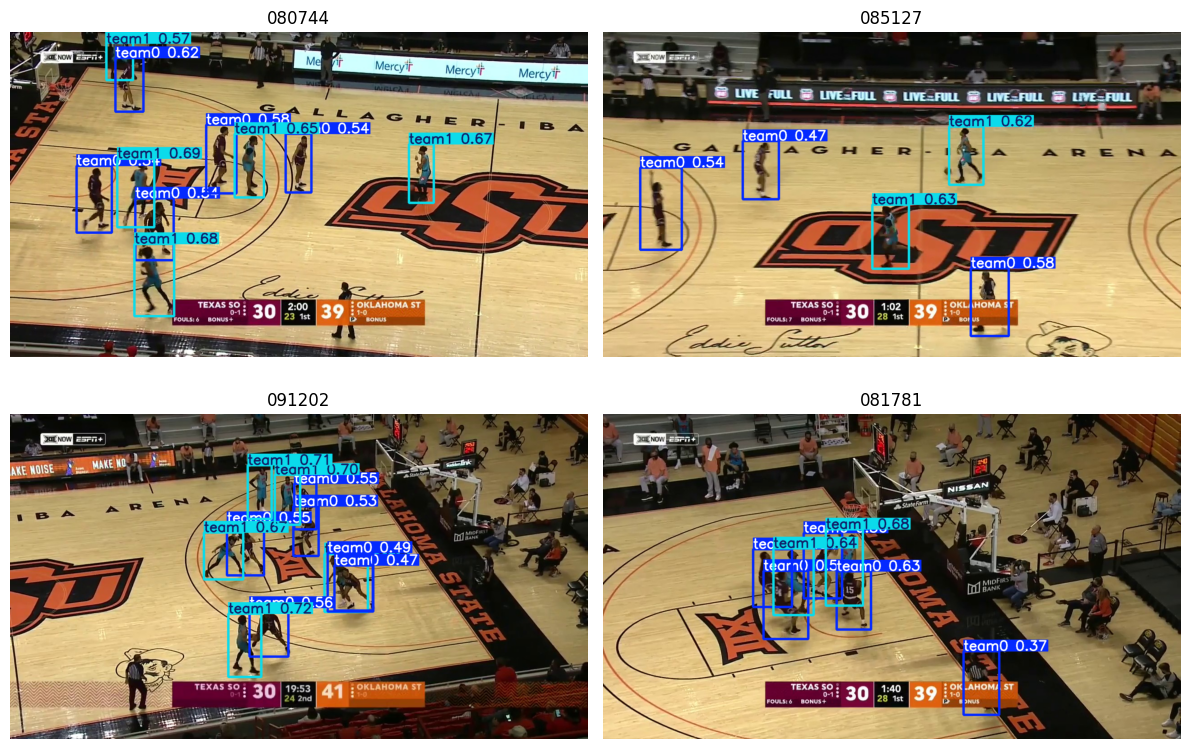

In [ ]:
VAL_IMAGES_DIR = "otus_basketball_dataset/valid/images"

# Список изображений
image_files = [f for f in os.listdir(VAL_IMAGES_DIR) if f.endswith(('.jpg', '.jpeg', '.png'))]
random_images = random.sample(image_files, 4)  # 4 случайных изображения

# Отображение
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.ravel()

for i, img_file in enumerate(random_images):
    image_path = os.path.join(VAL_IMAGES_DIR, img_file)
    results = model(image_path, imgsz=640)
    result_image = results[0].plot()
    result_image = cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB)
    axes[i].imshow(result_image)
    axes[i].set_title(os.path.splitext(img_file)[0])
    axes[i].axis("off")

plt.tight_layout()
plt.show()

## 2.6 Метрика  mAP (finetuning модель)

In [34]:
metrics = model.val()
print(f"COCO mAP: {metrics.box.map}")

Ultralytics 8.3.145  Python-3.11.9 torch-2.7.0+cu128 CPU (AMD Ryzen 7 PRO 8840HS w/ Radeon 780M Graphics)
val: Fast image access  (ping: 0.10.0 ms, read: 43.06.7 MB/s, size: 207.4 KB)


val: Scanning C:\Users\khari\OneDrive\Документы\GirRep\OtusCV\Lesson 17\Homework\otus_basketball_dataset\valid\labels.cache... 100 images, 0 backgrounds, 0 corrupt: 100%|██████████| 100/100 [00:00<?, ?it/s]
c:\Users\khari\OneDrive\Документы\GirRep\myenv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:13<00:00,  1.95s/it]


                   all        100        660      0.675      0.908      0.738      0.478
                 team0        100        377       0.77      0.907      0.802      0.519
                 team1        100        283      0.579      0.908      0.674      0.436
Speed: 0.4ms preprocess, 121.4ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs\detect\val
COCO mAP: 0.4777957926754975


# 3 Обучение модель со случайными весами (from scratch)

In [ ]:
# Загрузка случайной модели
model = YOLO("yolo11m.yaml")

In [ ]:
results = model.train(
    data="basketball.yaml",
    epochs=50,
    batch=8,
    imgsz=640,
    device="CUDA",  # GPU 
    name="basketball_detection",
    workers=0     
)

## 3.1 Инференс модели "с нуля"

In [ ]:
VAL_IMAGES_DIR = "otus_basketball_dataset/valid/images"

# Список изображений
image_files = [f for f in os.listdir(VAL_IMAGES_DIR) if f.endswith(('.jpg', '.jpeg', '.png'))]
random_images = random.sample(image_files, 4)  # 4 случайных изображения

# Отображение
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.ravel()

for i, img_file in enumerate(random_images):
    image_path = os.path.join(VAL_IMAGES_DIR, img_file)
    results = model(image_path, imgsz=640)
    result_image = results[0].plot()
    result_image = cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB)
    axes[i].imshow(result_image)
    axes[i].set_title(os.path.splitext(img_file)[0])
    axes[i].axis("off")

plt.tight_layout()
plt.show()

## 3.2 Метрика  mAP (from scratch)

In [ ]:
metrics = model.val()
print(f"COCO mAP: {metrics.box.map}")

# 4 Тестирование модель из коробки (from box)

## 4.1 Инференс для модели из коробки


image 1/1 c:\Users\khari\OneDrive\\GirRep\OtusCV\Lesson 17\Homework\otus_basketball_dataset\valid\images\095194.jpeg: 384x640 12 persons, 1 car, 199.9ms
Speed: 1.3ms preprocess, 199.9ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 c:\Users\khari\OneDrive\\GirRep\OtusCV\Lesson 17\Homework\otus_basketball_dataset\valid\images\083628.jpeg: 384x640 11 persons, 136.4ms
Speed: 2.1ms preprocess, 136.4ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 c:\Users\khari\OneDrive\\GirRep\OtusCV\Lesson 17\Homework\otus_basketball_dataset\valid\images\095684.jpeg: 384x640 13 persons, 132.9ms
Speed: 1.0ms preprocess, 132.9ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 c:\Users\khari\OneDrive\\GirRep\OtusCV\Lesson 17\Homework\otus_basketball_dataset\valid\images\091342.jpeg: 384x640 13 persons, 1 backpack, 132.2ms
Speed: 1.5ms preprocess, 132.2ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)


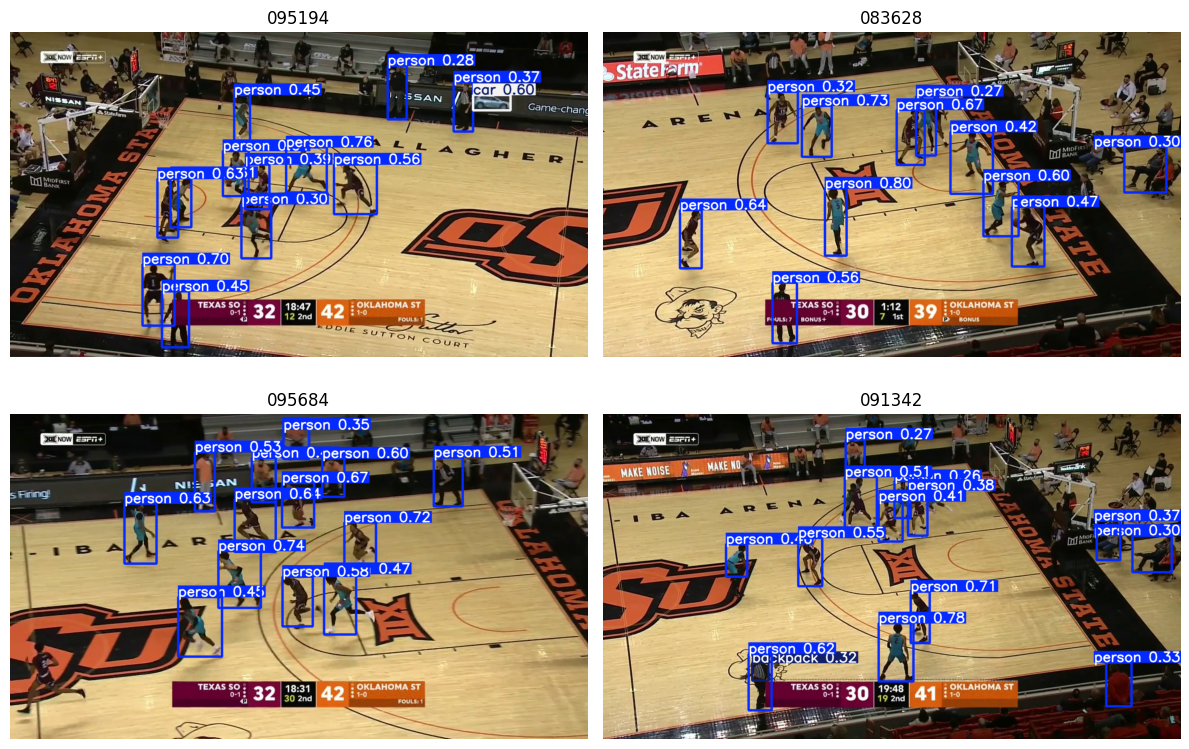

In [39]:
VAL_IMAGES_DIR = "otus_basketball_dataset/valid/images"

# Список изображений
image_files = [f for f in os.listdir(VAL_IMAGES_DIR) if f.endswith(('.jpg', '.jpeg', '.png'))]
random_images = random.sample(image_files, 4)  # 4 случайных изображения

# Отображение
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.ravel()

for i, img_file in enumerate(random_images):
    image_path = os.path.join(VAL_IMAGES_DIR, img_file)
    results = model(image_path, imgsz=640)
    result_image = results[0].plot()
    result_image = cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB)
    axes[i].imshow(result_image)
    axes[i].set_title(os.path.splitext(img_file)[0])
    axes[i].axis("off")

plt.tight_layout()
plt.show()

## 4.2 Метрика COCO для модели из коробки

In [40]:
model = YOLO('yolo11m.pt')
metrics = model.val(
    data='basketball.yaml',  
    batch=8,           
    imgsz=640,          
    conf=0.001,                    
    device='cpu',   
)
print(f"COCO mAP: {metrics.box.map}")

Ultralytics 8.3.145  Python-3.11.9 torch-2.7.0+cu128 CPU (AMD Ryzen 7 PRO 8840HS w/ Radeon 780M Graphics)
YOLO11m summary (fused): 125 layers, 20,091,712 parameters, 0 gradients, 68.0 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 2054.1514.1 MB/s, size: 209.5 KB)


val: Scanning C:\Users\khari\OneDrive\Документы\GirRep\OtusCV\Lesson 17\Homework\otus_basketball_dataset\valid\labels.cache... 100 images, 0 backgrounds, 0 corrupt: 100%|██████████| 100/100 [00:00<?, ?it/s]
c:\Users\khari\OneDrive\Документы\GirRep\myenv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:12<00:00,  1.03it/s]


                   all        100        660      0.645      0.312      0.136     0.0582
                person        100        377       0.29      0.625       0.27      0.116
               bicycle        100        283          1          0     0.0025   0.000749
Speed: 0.5ms preprocess, 115.7ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to runs\detect\val2
COCO mAP: 0.05824088358478334


# 5 Выводы и сводная таблица

## 5.1 Таблица

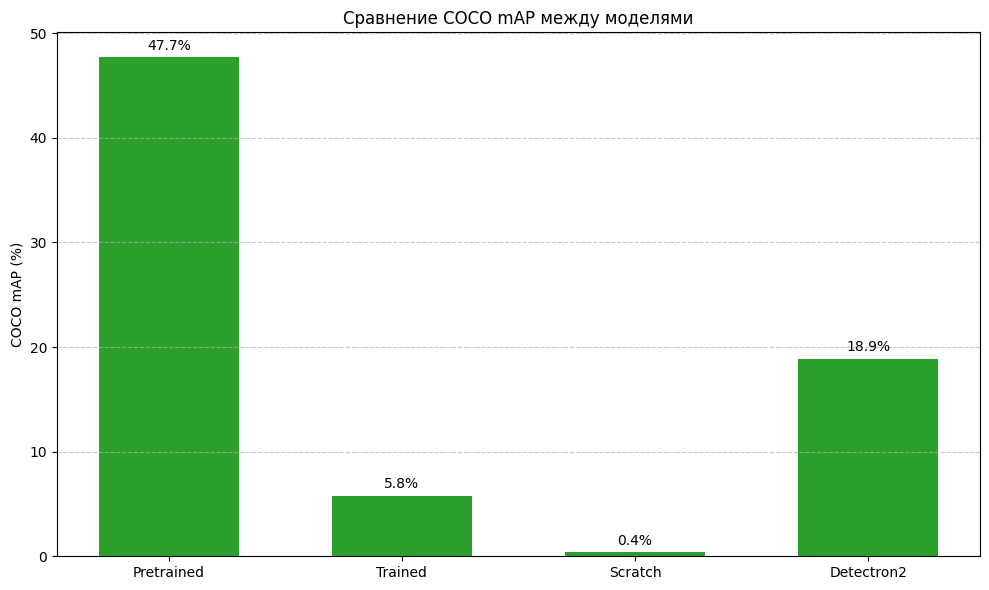

In [52]:
# Данные для сводной таблицы
data = {
    "Model": [
        "Pretrained",
        "Trained",
        "Scratch",
        "Detectron2"
    ],
    "COCOmAP": [47.7, 5.8, 0.40, 18.9]
}
df = pd.DataFrame(data)
x = np.arange(len(df))  # Позиции моделей по оси X
width = 0.6             # Ширина столбцов
fig, ax = plt.subplots(figsize=(10, 6))
rects = ax.bar(x, df['COCOmAP'], width, color='#2ca02c')

# Подписи осей и заголовок
ax.set_ylabel('COCO mAP (%)')
ax.set_title('Сравнение COCO mAP между моделями')
ax.set_xticks(x)
ax.set_xticklabels(df['Model'])
ax.grid(True, axis='y', linestyle='--', alpha=0.7)

# Добавление значений на столбцы
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.1f}%',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects)

plt.tight_layout()
plt.show()

## Вывод
1) Detectron2:
    - Установка detectron2 должно быть отдельным заданием.. Потрачено много ресурсов в попытках поставить этот фреймворк на виртуальное окружение (разные версии torch/cuda и другие инструменты). В итоге был запущен Colab по уроку, но после окончания времени пользования видеокартой, всякий интерес и желание работать с detectron2 пропало.
    - Считаю что detectron2 с поставленой задачей не справился, модель требует доработки (подбора гиперпараметров). Была взята модель faster_rcnn_R_101_FPN_3x.
    - При осмотре результатов могу отметить что модель может выделить облась интереса (баскетбольное поле). В этой области хорошо находит игроков, так как была ранее обучена на COCO датасете. Тоесть Precision высокий.
    - Recall (Полнота) удовлетворительный, игроки обнаруживаются, а так же захватываются несколько "ошибочных" обьектов.
    - IoU удовлетворительный, bbox корректны.
2) Ultralytics:
    - YOLO и ее инструменты реализованы отлично!
    - Метрики показали оценку модели выше чем detectrin2, но обективно сравнить архитекруты YOLO и Faster R-CNN не получится, так как необходимо больше экспериментов и опыта.
3) Trained & Scratch
    - Работа с моделями без "fine tuning" показала, как важно дообучать модель чтобы получить вменяемый результат. 
    - Любые полученые веса лучше чем рандомные. 
4) Выделить какую-то архетекруту/подход по скорости обучения, инференса не могу, все спаравились одинакого - датасет был маленький, настройки дефолтные, инференс не реалтайм.

